In [105]:
using Plots, Statistics, NaNStatistics, LinearAlgebra, Serialization, ParticleFilters

include("./utils/import.jl")
include("./utils/figs.jl")
using .Import
using .Figs

## Set Parameters
### Experiment Names

In [106]:
y8_expID = "22914_23519"
y9_expID = "22915_02260"
y99_expID = "22915_095011"
y999_expID = "22927_082018"

"22927_082018"

### Experiment Parameters

In [110]:
runs = 20
actions = ["C1", "C2", "C3", "B1", "B2"]
y8, y9, y99, y999 = 0.8, 0.9, 0.99, 0.999;

### Plotting Parameters

In [111]:
window = 100
y_labels = ["y=0.8" "y=0.9" "y=0.99" "y=0.999"];

## Import Data

In [4]:
@time begin
    println("importing y="*string(y8)*" (exp "*y8_expID*") data...")
    y8_s, y8_t, y8_a, y8_r, y8_beliefs, y8_final_states, y8_avg_belief, y8_avg_belief_u = Import.import_experiment(y8_expID, runs)
end;

importing y=0.8 (exp 22914_23519) data...
183.612348 seconds (1.60 G allocations: 61.515 GiB, 4.24% gc time, 0.45% compilation time)


In [5]:
@time begin
    println("importing y="*string(y9)*" (exp "*y9_expID*") data...")
    y9_s, y9_t, y9_a, y9_r, y9_beliefs, y9_final_states, y9_avg_belief, y9_avg_belief_u = Import.import_experiment(y9_expID, runs)
end;

importing y=0.9 (exp 22915_02260) data...
182.251206 seconds (1.59 G allocations: 61.248 GiB, 4.20% gc time)


In [6]:
@time begin
    println("importing y="*string(y99)*" (exp "*y99_expID*") data...")
    y99_s, y99_t, y99_a, y99_r, y99_beliefs, y99_final_states, y99_avg_belief, y99_avg_belief_u = Import.import_experiment(y99_expID, runs)
end;

importing y=0.99 (exp 22915_095011) data...
184.696750 seconds (1.59 G allocations: 61.251 GiB, 4.41% gc time)


In [7]:
@time begin
    println("importing y="*string(y999)*" (exp "*y999_expID*") data...")
    y999_s, y999_t, y999_a, y999_r, y999_beliefs, y999_final_states, y999_avg_belief, y999_avg_belief_u = Import.import_experiment(y999_expID, runs)
end;

importing y=0.999 (exp 22927_082018) data...
185.334361 seconds (1.59 G allocations: 61.259 GiB, 3.78% gc time)


## Analysis
### General

In [12]:
# for these experiments, all runs have the same start state & optimal action
optimal_action = Import.get_optimal_arm(y8_s[1])

println("State:")
println(string(y8_s[1])*"\n")
println("Highest-Reward Arm:")
println(string(optimal_action))

LoadError: MethodError: no method matching get_optimal_arm(::State)
[0mClosest candidates are:
[0m  get_optimal_arm([91m::Main.Import.State[39m) at ~/Documents/Workspaces/github workspace/ATS/utils/import.jl:29

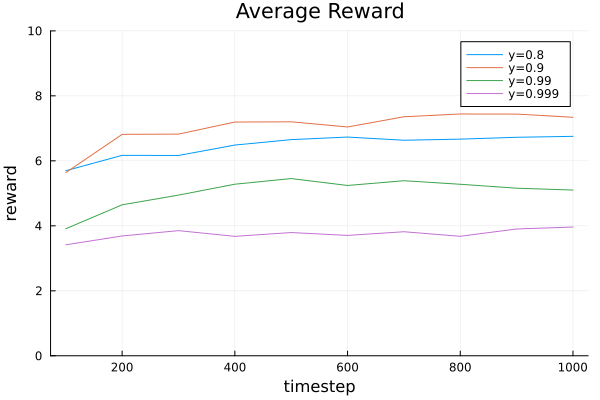

In [113]:
Figs.plot_avg_r_multiple_experiments([y8_r, y9_r, y99_r, y999_r], window, y_labels, "Average Reward")

In [18]:
# uncomment to print histograms of first three actions

# println("\ny="*string(y8)*" Histograms (exp "*y8_expID*")")
# Import.print_action_hist(y8_a, actions)

# println("\ny="*string(y9)*" Histograms (exp "*y9_expID*")")
# Import.print_action_hist(y9_a, actions)

# println("\ny="*string(y99)*" Histograms (exp "*y99_expID*")")
# Import.print_action_hist(y99_a, actions)

# println("\ny="*string(y999)*" Histograms (exp "*y999_expID*")")
# Import.print_action_hist(y999_a, actions)


y=0.8 Histograms (exp 22914_23519)
First Action
C1:	6.0
C2:	7.0
C3:	7.0
B1:	0.0
B2:	0.0

Second Action
C1:	5.0
C2:	10.0
C3:	4.0
B1:	1.0
B2:	0.0

Third Action
C1:	11.0
C2:	3.0
C3:	6.0
B1:	0.0
B2:	0.0

y=0.9 Histograms (exp 22915_02260)
First Action
C1:	6.0
C2:	7.0
C3:	3.0
B1:	1.0
B2:	3.0

Second Action
C1:	9.0
C2:	4.0
C3:	4.0
B1:	2.0
B2:	1.0

Third Action
C1:	4.0
C2:	6.0
C3:	7.0
B1:	2.0
B2:	1.0

y=0.99 Histograms (exp 22915_095011)
First Action
C1:	8.0
C2:	5.0
C3:	2.0
B1:	1.0
B2:	4.0

Second Action
C1:	5.0
C2:	1.0
C3:	5.0
B1:	5.0
B2:	4.0

Third Action
C1:	3.0
C2:	4.0
C3:	9.0
B1:	3.0
B2:	1.0

y=0.999 Histograms (exp 22927_082018)
First Action
C1:	5.0
C2:	2.0
C3:	5.0
B1:	5.0
B2:	3.0

Second Action
C1:	7.0
C2:	4.0
C3:	4.0
B1:	1.0
B2:	4.0

Third Action
C1:	4.0
C2:	2.0
C3:	9.0
B1:	2.0
B2:	3.0


## Action Distributions

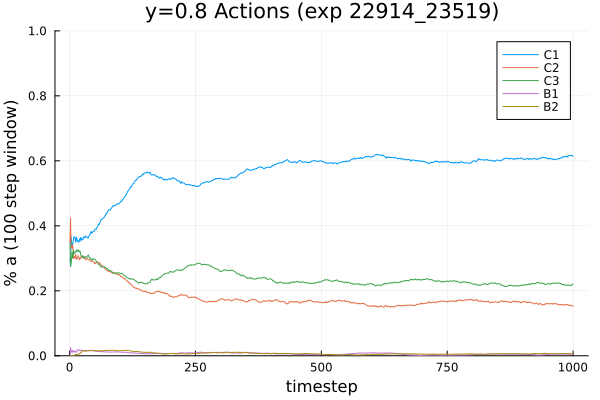

In [19]:
Figs.plot_proportion_actions_all(y8_a, actions, window, "y="*string(y8)*" Actions (exp "*y8_expID*")")

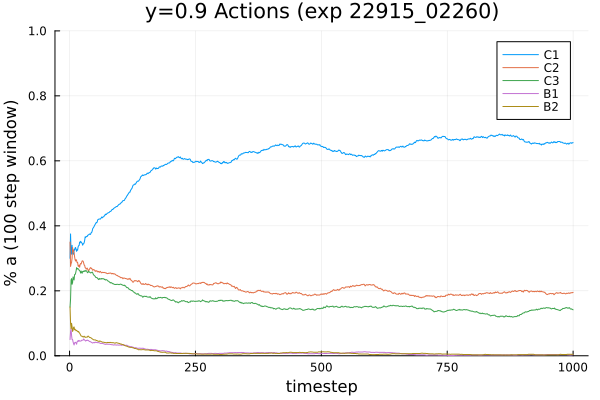

In [20]:
Figs.plot_proportion_actions_all(y9_a, actions, window, "y="*string(y9)*" Actions (exp "*y9_expID*")")

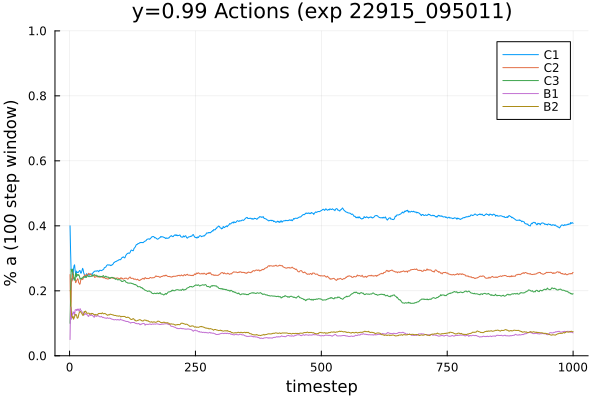

In [21]:
Figs.plot_proportion_actions_all(y99_a, actions, window, "y="*string(y99)*" Actions (exp "*y99_expID*")")

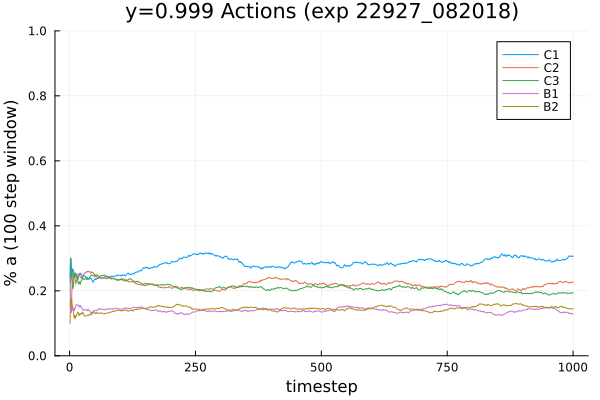

In [22]:
Figs.plot_proportion_actions_all(y999_a, actions, window, "y="*string(y999)*" Actions (exp "*y999_expID*")")

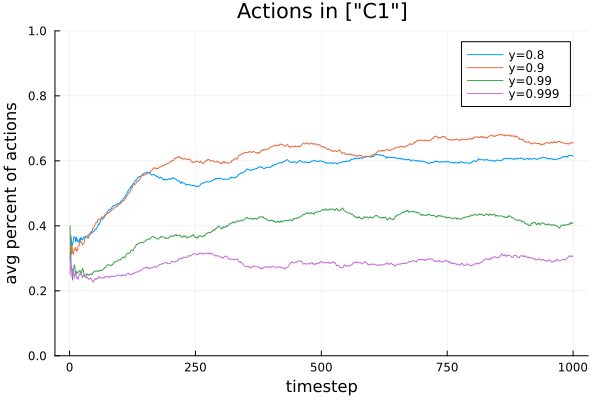

In [134]:
Figs.plot_actions_in_list_rolling_multiple_experiments([y8_a, y9_a, y99_a, y999_a], ["C1"], 100, y_labels, "Actions in ")

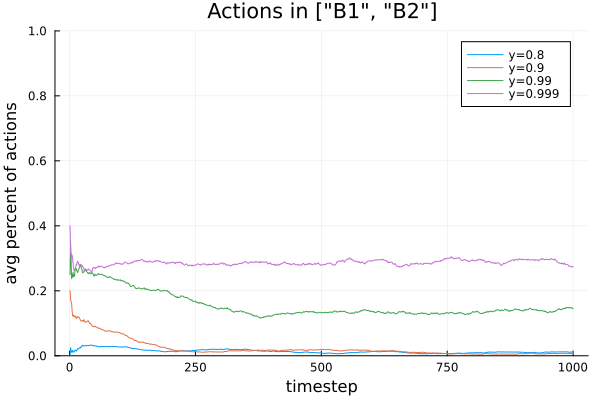

In [135]:
Figs.plot_actions_in_list_rolling_multiple_experiments([y8_a, y9_a, y99_a, y999_a], ["B1", "B2"], 100, y_labels, "Actions in ")

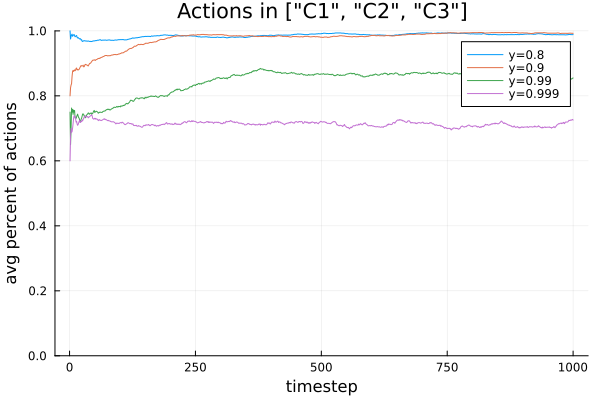

In [136]:
Figs.plot_actions_in_list_rolling_multiple_experiments([y8_a, y9_a, y99_a, y999_a], ["C1", "C2", "C3"], 100, y_labels, "Actions in ")

In [ ]:
# proportion of actions that are high-B



## Belief Dynamics

In [ ]:
s, t, a, r = Import.get_star(expID, runs);

In [ ]:
#for these experiments, all runs have the same start state & optimal action
optimal_action = Import.get_optimal_arm(s[1])

println("State:")
println(string(s[1])*"\n")
println("Optimal Action:")
println(string(optimal_action))

In [ ]:
typeof(a)

In [ ]:
Import.print_action_hist(a, actions)

In [ ]:
window = 100;

In [ ]:
Figs.plot_proportion_actions_all(a, actions, window, y, expID, runs)

In [ ]:
Figs.plot_proportion_actions_in_list_rolling(a, [optimal_action], window, y, expID)

In [ ]:
C_actions = ["C1", "C2", "C3"]
Figs.plot_proportion_actions_in_list_rolling(a, C_actions, window, y, expID)

In [ ]:
B_actions = ["B1", "B2"]
Figs.plot_proportion_actions_in_list_rolling(a, B_actions, window, y, expID)

In [ ]:
Figs.plot_proportion_high_B(a, window, y, expID)

In [ ]:
y8_expID = "22914_23519"
y9_expID = "22915_02260"
y99_expID = "22915_095011"
y999_expID = "22927_082018"

In [ ]:
@time begin
    println("importing y=0.8 (exp "*y8_expID*") data...")
    y8_s, y8_t, y8_a, y8_r, y8_beliefs, y8_final_states, y8_avg_belief, y8_avg_belief_u = Import.import_experiment(y8_expID, runs)
end;

In [ ]:
@time begin
    println("importing y=0.9 (exp "*y9_expID*") data...")
    y9_s, y9_t, y9_a, y9_r, y9_beliefs, y9_final_states, y9_avg_belief, y9_avg_belief_u = Import.import_experiment(y9_expID, runs)
end;

In [ ]:
@time begin
    println("importing y=0.99 (exp "*y99_expID*") data...")
    y99_s, y99_t, y99_a, y99_r, y99_beliefs, y99_final_states, y99_avg_belief, y99_avg_belief_u = Import.import_experiment(y99_expID, runs)
end;

In [ ]:
@time begin
    println("importing y=0.999 (exp "*y999_expID*") data...")
    y999_s, y999_t, y999_a, y999_r, y999_beliefs, y999_final_states, y999_avg_belief, y999_avg_belief_u = Import.import_experiment(y999_expID, runs)
end;

In [ ]:
plot(
    1:length(y8_avg_belief),
    [y8_avg_belief, y9_avg_belief, y99_avg_belief, y999_avg_belief],
    labels = ["y=0.8" "y=0.9" "y=0.99" "y=0.999"],
    title = "belief on converged state",
    legend = :bottomright
)

In [ ]:
function print_state(s::State)
    println("\t u: ", s.u)
    println("\t d1: ", s.d[1], "\t (exp val ", dot(s.u, s.d[1]), ")")
    println("\t d1: ", s.d[2], "\t (exp val ", dot(s.u, s.d[2]), ")")
    println("\t d1: ", s.d[3], "\t (exp val ", dot(s.u, s.d[3]), ")")
end

true_state = y8_s[1]

println("\ntrue state")
print_state(true_state)

println("\ny=0.8 final states")
for s in y8_final_states
    println("")
    print_state(s)
end

println("\ny=0.9 final states")
for s in y9_final_states
    println("")
    print_state(s)
end

println("\ny=0.99 final states")
for s in y99_final_states
    println("")
    print_state(s)
end

println("\ny=0.999 final states")
for s in y999_final_states
    println("")
    print_state(s)
end


In [ ]:
# NOTE: while these are almost identical, they do differ slightly
plot(
    1:length(y8_avg_belief),
    [y8_avg_belief_u, y9_avg_belief_u, y99_avg_belief_u, y999_avg_belief_u],
    labels = ["y=0.8" "y=0.9" "y=0.99" "y=0.999"],
    title = "belief on converged utility function",
    legend = :bottomright
)